In [49]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_regression
from matplotlib import pyplot
from pandas import DataFrame
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from hypopt import GridSearch 
from random import randrange
import matplotlib.pyplot as plt

### Single iteration:

$$
y_i = a_1 * x_{1i} + a_2 * x_{2i} + D_i * x_{i3} + \epsilon_i
$$

$$
x_1, x_3 \sim \mathcal{N}(0, 1)
$$
$$
x_2 \sim \mathcal{N}(0.5,1)
$$
$$
\epsilon \sim \mathcal{N}(0, 0.8^2)
$$

$$
pr(D_i = 1) = 2/3
$$

<img src="test2.png">

In [150]:
#function to train the tree on training set, find best max_depth on validation set, and predict on test set
def DT_test(X_tr, y_tr, X_v, y_v, X_test, y_test, state, depth):
    yhat = []
    leaf = []
    score_max = 0
    max_depth_index = 1
    for i in depth:
        r = tree.DecisionTreeRegressor(max_depth = i, random_state = state)
        r = r.fit(X_tr, y_tr)
        score = r.score(X_v, y_v)
        #print(score)
        #find best parameter on validation set
        if score > score_max:
            score_max = score
            max_depth_index = i
    #fit on test set with best param
    r2 = tree.DecisionTreeRegressor(max_depth = max_depth_index)
    r2 = r2.fit(X_tr, y_tr)
    score_test = r2.score(X_test, y_test)
    yhat = r2.predict(X_test)
    leaf = r2.get_n_leaves()
    mse_test = mse(y_test, yhat)
    depth_idx = r2.get_depth()
    return score_test, depth_idx, mse_test, leaf

In [151]:
n = 500
a1 = 2
a2 = 0.5

In [149]:
x1 = np.random.normal(loc = 0.0, scale = 1.0, size = (n,1))
x2 = np.random.normal(loc = 0.0, scale = 1.0, size = (n,1))
x3_ = np.random.normal(loc = 0.5, scale = 1.0, size = (n,1))
e = np.random.normal(loc = 0.0, scale = 0.8, size = (n,1))
d = np.random.choice([0, 1], size=(n,1), p=[1./3, 2./3])
x3 = np.multiply(x3_, d)

y = np.add(x1*a1, x2*a2)
y = np.add(y, x3)
y = np.add(y, e)
X = np.concatenate((x1,x2), axis=1)
X = np.concatenate((X,x3), axis=1)
#data = pd.DataFrame({'X1': x1[:,0], 'X2': x2[:,0], 'y': y[:,0]}, columns=['X1', 'X2', 'y'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5)

#same state for swapping
state = randrange(999999)

depth = np.arange(2,10)
#swapping between training and validation sets
tr_val = DT_test(X_train, y_train, X_val, y_val, X_test, y_test, state, depth)
val_tr = DT_test(X_val, y_val, X_train, y_train, X_test, y_test, state, depth)
print(tr_val)
print(val_tr)

(0.7290591452348157, 9, 1.4332055412598848, 127)
(0.569869473516093, 6, 2.275276847989714, 48)


In [139]:
accuracy_diff = []
depth_diff = []
mse_diff = []
leaves_diff = []
mse1 = []
mse2 = []


for j in range(1000):
    x1 = np.random.normal(loc = 0.0, scale = 1.0, size = (n,1))
    x2 = np.random.normal(loc = 0.5, scale = 1.0, size = (n,1))
    x3_ = np.random.normal(loc = 0.0, scale = 1.0, size = (n,1))
    e = np.random.normal(loc = 0.0, scale = 0.8, size = (n,1))
    d = np.random.choice([0, 1.0], size=(n,1), p=[1./3, 2./3])
    x3 = np.multiply(x3_, d)

    y = np.add(x1*a1, x2*a2)
    y = np.add(y, x3)
    y = np.add(y, e)
    X = np.concatenate((x1,x2), axis=1)
    X = np.concatenate((X,x3), axis=1)
    #data = pd.DataFrame({'X1': x1[:,0], 'X2': x2[:,0], 'y': y[:,0]}, columns=['X1', 'X2', 'y'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5)

    #same state for swapping
    state = randrange(999999)

    depth = np.arange(2,10)
    tr_val = DT_test(X_train, y_train, X_val, y_val, X_test, y_test, state, depth)
    val_tr = DT_test(X_val, y_val, X_train, y_train, X_test, y_test, state, depth)
    
    accuracy_diff.append(abs(tr_val[0] - val_tr[0]))
    depth_diff.append(abs(tr_val[1] - val_tr[1]))
    mse_diff.append(abs(tr_val[2] - val_tr[2]))
    leaves_diff.append(abs(tr_val[3] - val_tr[3]))
    mse1.append(tr_val[2])
    mse2.append(val_tr[2])

average mse1: 1.5737649689139066
average mse2: 1.5839975672120823


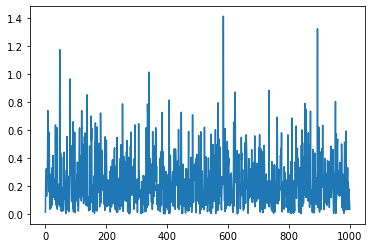

In [153]:
print('average mse1: '  + str(np.mean(mse1)))
print('average mse2: ' + str(np.mean(mse2)))
plt.plot(mse_diff)

(array([230., 361.,   0., 227.,   0., 138.,  34.,   0.,   6.,   4.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

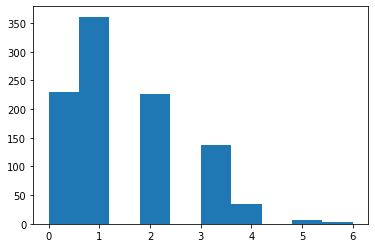

In [141]:
plt.hist(depth_diff)

(array([214., 222., 159., 128., 118.,  65.,  44.,  22.,  21.,   7.]),
 array([  0. ,  10.9,  21.8,  32.7,  43.6,  54.5,  65.4,  76.3,  87.2,
         98.1, 109. ]),
 <BarContainer object of 10 artists>)

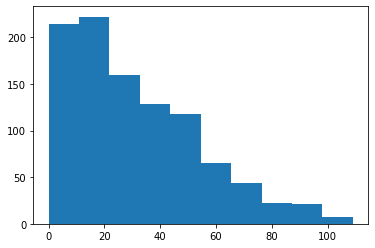

In [134]:
plt.hist(leaves_diff)